https://covid19.who.int/WHO-COVID-19-global-data.csv

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import glob
import os

Load dataset and prepare df. Keeping only those columns, that are not directly computed out of new deaths, and have the highest correlation

In [12]:
folder_path = "./data"
date_column = "period"
target_column = "value"
all_files = glob.glob(os.path.join(folder_path , "electricity?.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.sort_values(by=[target_column])

,subba,value,period,parent
2294201,TSGT,-1144,2021-02-16 08:00:00,PNM
599135,KCEC,-7,2023-06-24 19:00:00,PNM
419605,KCEC,-5,2023-09-22 22:00:00,PNM
599072,KCEC,-5,2023-06-24 20:00:00,PNM
431685,KCEC,-5,2023-09-16 21:00:00,PNM
...,...,...,...,...
622493,SPS,429289,2023-06-13 02:00:00,SWPP
622490,OKGE,434669,2023-06-13 02:00:00,SWPP
622462,CSWS,661194,2023-06-13 02:00:00,SWPP
1812359,DOM,1038460000,2021-10-19 04:00:00,PJM


In [4]:
df_graph = df.groupby(date_column).sum().reset_index()
df_graph.set_index(date_column, inplace=True)

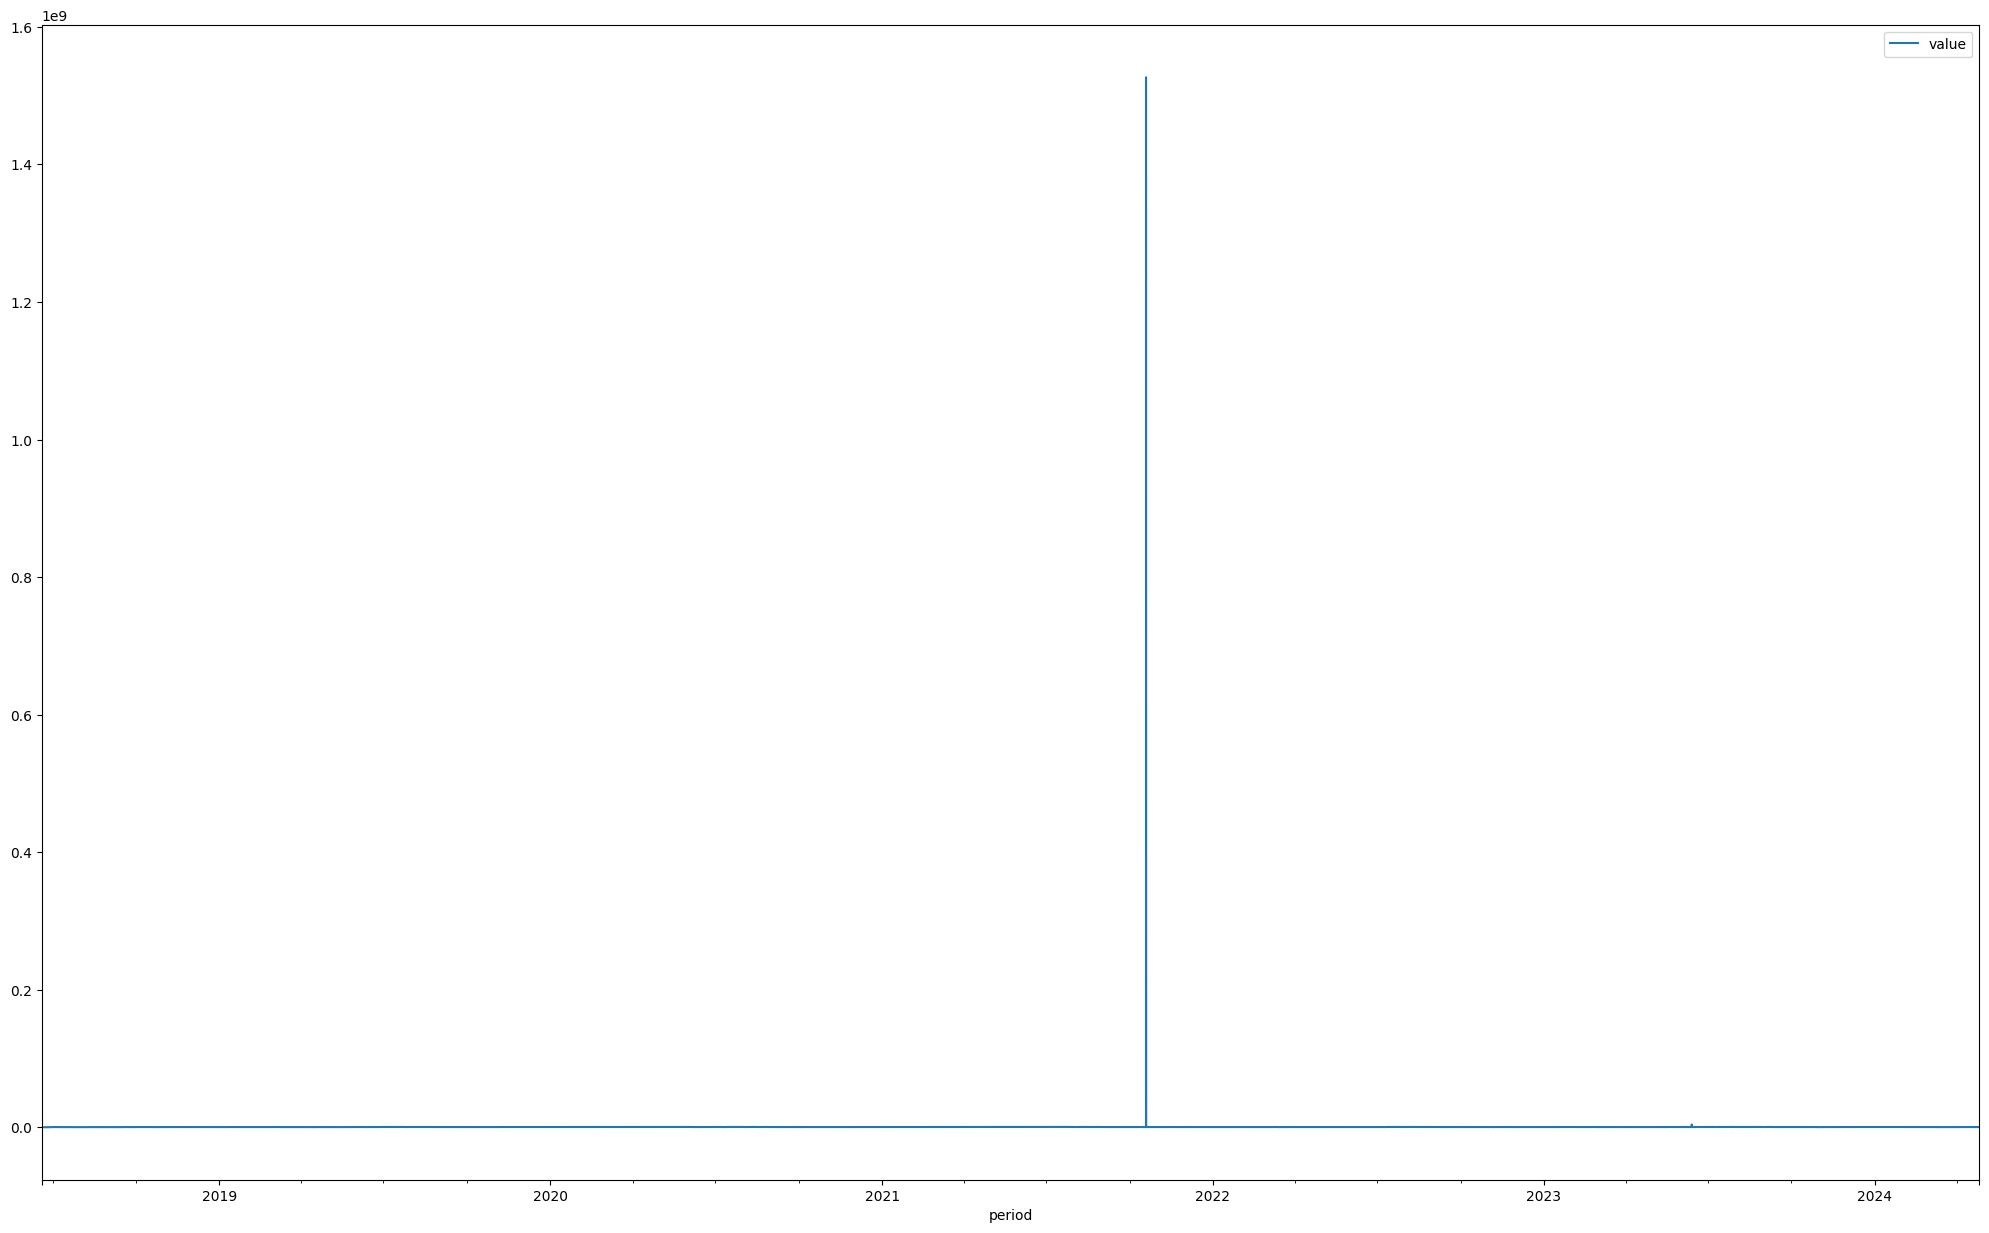

In [5]:
plot_cols = [target_column]
plot_features = df_graph[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(25, 15))

In [6]:
print(f"First date in dataset {df[date_column].min()}")
print(f"Last date in dataset {df[date_column].max()}")
print(f"Number of rows {len(df)}")
print(f"Number of subba {len(df['subba'].unique())}")
print(f"Number of parents {len(df['parent'].unique())}")

First date in dataset 2018-06-19 05:00:00
Last date in dataset 2024-04-25 07:00:00
Number of rows 4062708
Number of subba 84
Number of parents 8


In [4]:
number_of_outliers = 1
for _ in range(number_of_outliers):
    outlier = df[df[target_column] == df[target_column].min()].iloc[0]
    row_index = outlier.name
    outlier_date = outlier[date_column]
    outlier_subba = outlier['subba']
    values = []
    date_before = outlier_date - pd.DateOffset(days=7)
    date_after = outlier_date + pd.DateOffset(days=7)
    rows = df[(df['subba'] == outlier_subba) & (df[date_column] >= date_before) & (df[date_column] <= date_after)][target_column]
    values.extend(rows.values)
    if values:
        average = sum(values) / len(values)
        df.at[row_index, target_column] = average

In [5]:
df = df.groupby([date_column, 'parent']).sum().reset_index()
df.set_index([date_column, 'parent'], inplace=True)
df.drop(columns=['subba'], inplace=True)

In [6]:
df.sort_values(by=[target_column])

,,value
period,parent,
2020-11-22 16:00:00,PNM,0.000000e+00
2020-11-22 15:00:00,PNM,0.000000e+00
2020-11-21 09:00:00,PNM,0.000000e+00
2020-11-21 10:00:00,PNM,0.000000e+00
2020-11-22 17:00:00,PNM,0.000000e+00
...,...,...
2023-06-26 21:00:00,PJM,1.923980e+05
2020-09-03 21:00:00,PJM,2.529820e+05
2023-06-13 02:00:00,SWPP,3.621098e+06


In [6]:
number_of_outliers = 3
for _ in range(number_of_outliers):
    outlier = df[df[target_column] == df[target_column].max()].iloc[0]
    row_index = outlier.name  # row_index is now a tuple (date, parent)
    outlier_date, outlier_parent = row_index
    values = []
    for i in range(1, 8):
        date_before = outlier_date - pd.DateOffset(days=i)
        date_after = outlier_date + pd.DateOffset(days=i)
        # Use loc to handle multi-index properly
        if (date_before, outlier_parent) in df.index:
            values.append(df.loc[(date_before, outlier_parent), target_column])
        if (date_after, outlier_parent) in df.index:
            values.append(df.loc[(date_after, outlier_parent), target_column])
    if values:
        average = sum(values) / len(values)
        df.at[row_index, target_column] = average

In [7]:
df.reset_index(inplace=True)

In [10]:
df.sort_values(by=[target_column])

,period,parent,value
157025,2020-11-22 16:00:00,PNM,0.0
157017,2020-11-22 15:00:00,PNM,0.0
156777,2020-11-21 09:00:00,PNM,0.0
156785,2020-11-21 10:00:00,PNM,0.0
157033,2020-11-22 17:00:00,PNM,0.0
...,...,...,...
344205,2023-07-27 00:00:00,PJM,178158.0
764,2018-07-04 13:00:00,PJM,178444.0
384185,2024-02-23 15:00:00,PJM,188198.0
338421,2023-06-26 21:00:00,PJM,192398.0


In [11]:
df_graph = df.groupby(date_column).sum().reset_index()
df_graph.set_index(date_column, inplace=True)

Plot the dataset

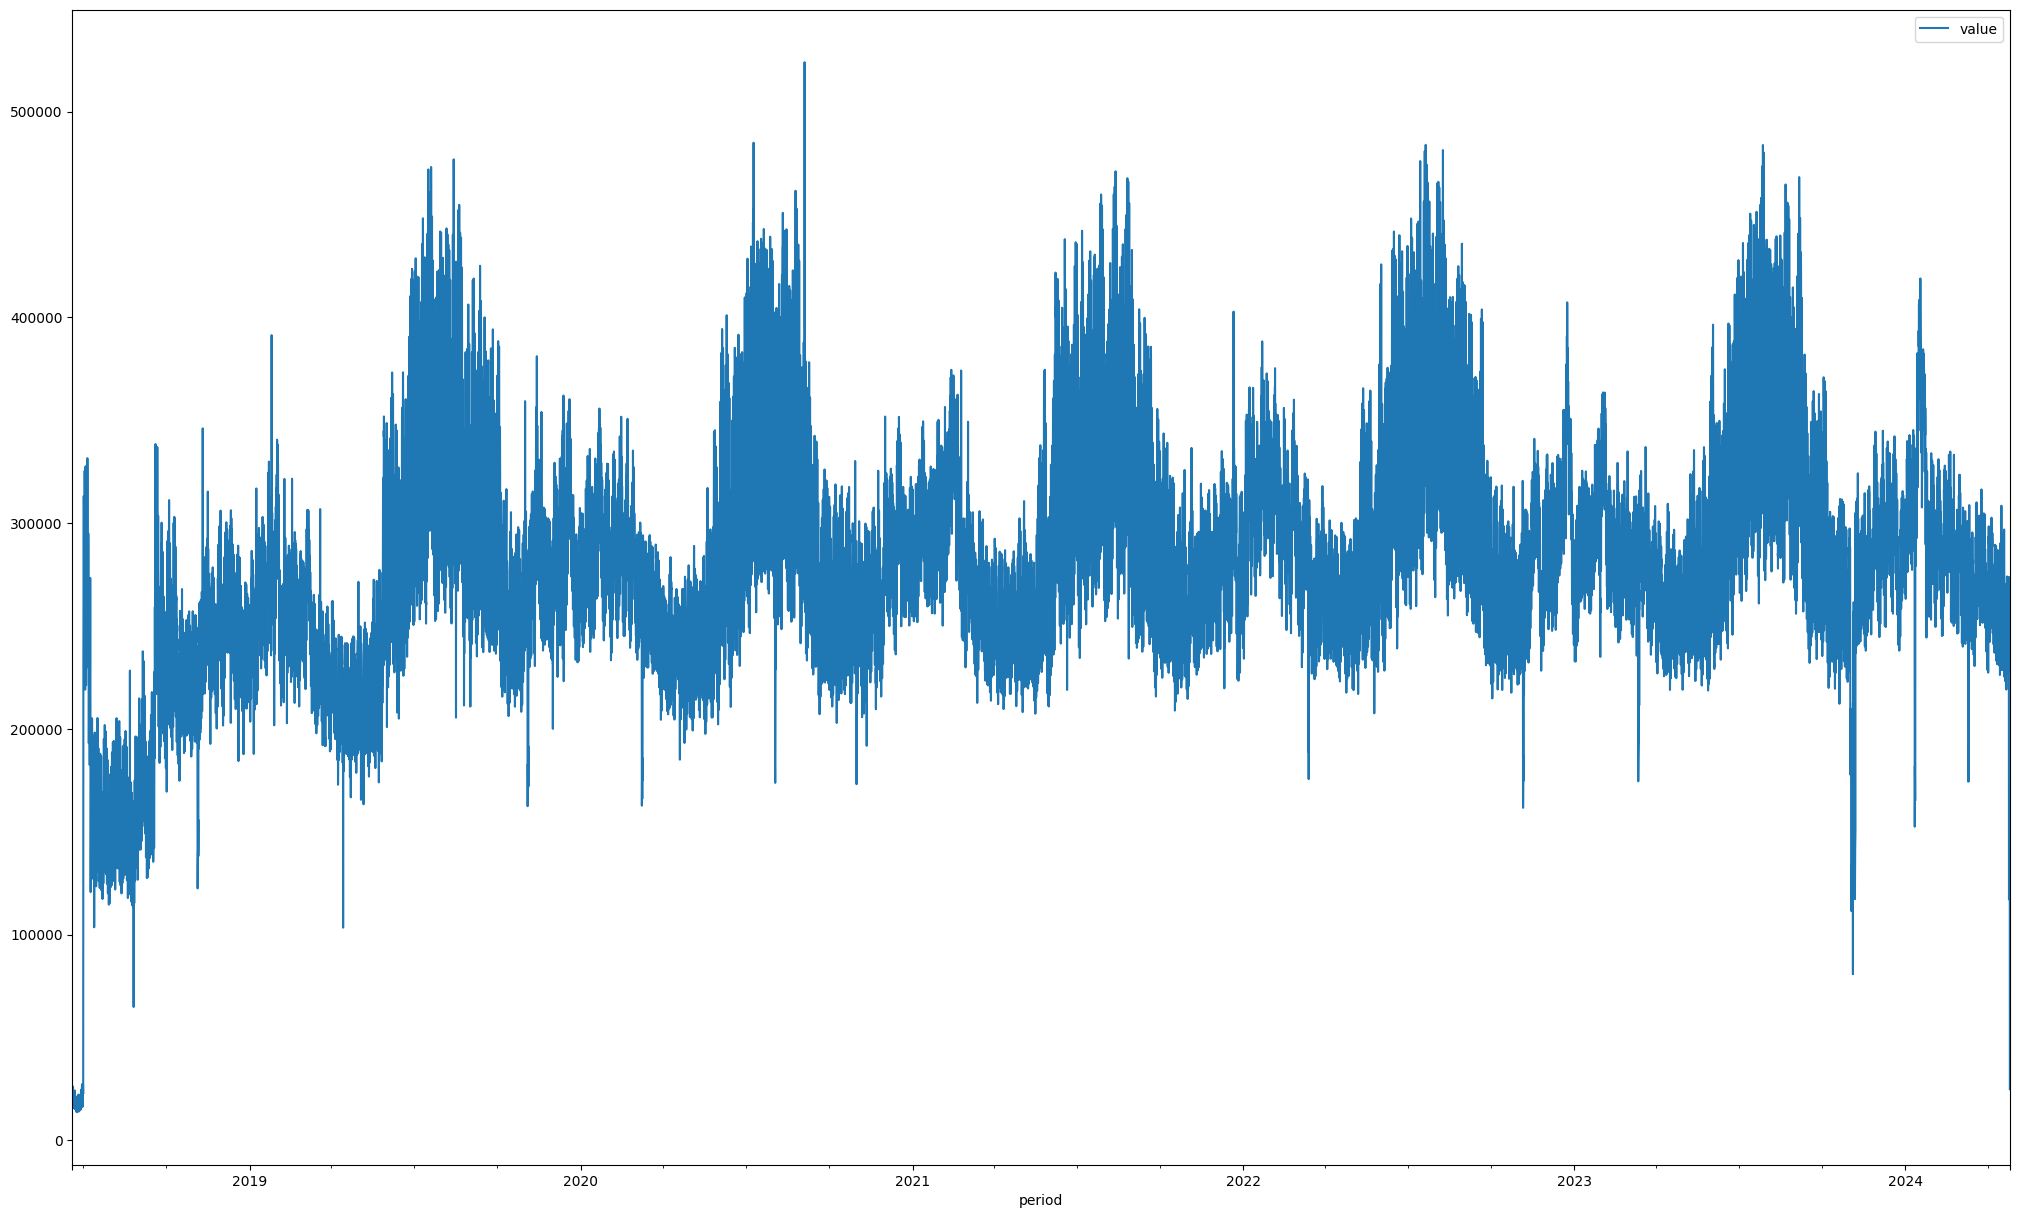

In [12]:
plot_cols = [target_column]
plot_features = df_graph[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(25, 15))

Display first values

In [15]:
df_graph.head()

,parent,value
period,,
2018-06-19 05:00:00,NYIS,20137.0
2018-06-19 06:00:00,NYIS,19225.0
2018-06-19 07:00:00,NYIS,18540.0
2018-06-19 08:00:00,NYIS,18142.0
2018-06-19 09:00:00,NYIS,18136.0


In [16]:
df_graph.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,51291.0,284203.97713,58283.858899,13699.0,252270.5,281331.0,312130.0,524055.0


Decompose the time series into trend, seasonal, and residual components and plot them

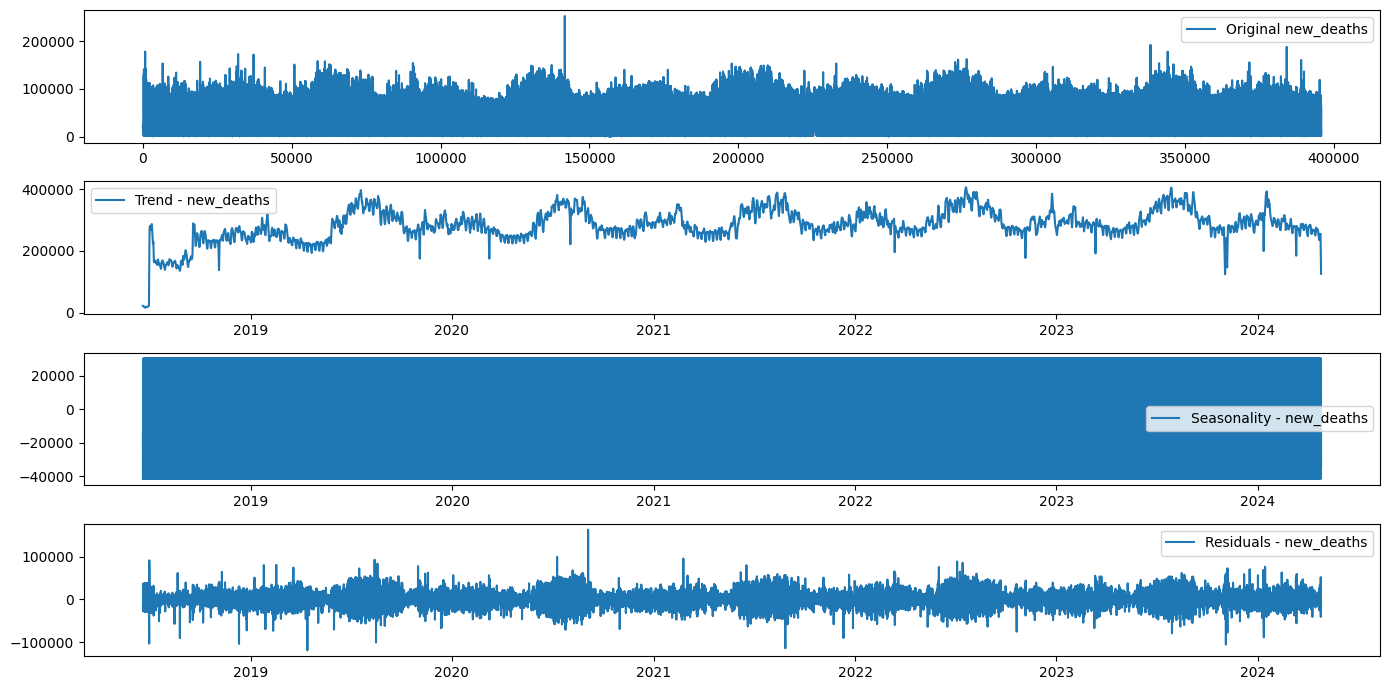

count    395723.000000
mean      36836.641264
std       29871.968284
min           0.000000
25%       14755.000000
50%       26576.000000
75%       61068.500000
max      252982.000000
Name: value, dtype: float64


In [21]:
decomposition = seasonal_decompose(df_graph[target_column], model="aditive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(df[target_column], label=f"Original value")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(trend, label=f"Trend - value")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal, label=f"Seasonality - value")
plt.legend(loc="best")

plt.subplot(414)
plt.plot(residual, label=f"Residuals - value")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


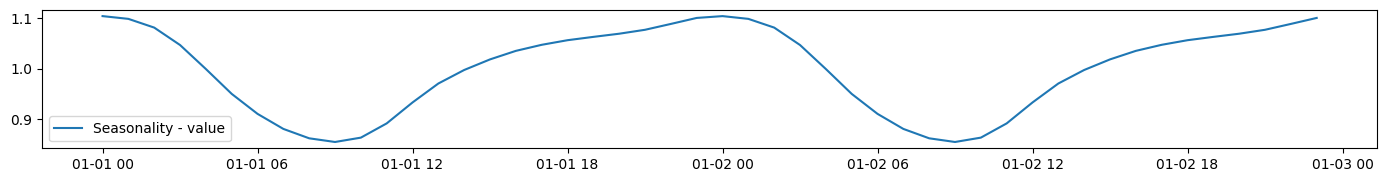

In [29]:
seasonal_closer = decomposition.seasonal["2020-01-01": "2020-01-02"]

plt.figure(figsize=(14, 7))
plt.subplot(413)
plt.plot(seasonal_closer, label=f"Seasonality - value")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

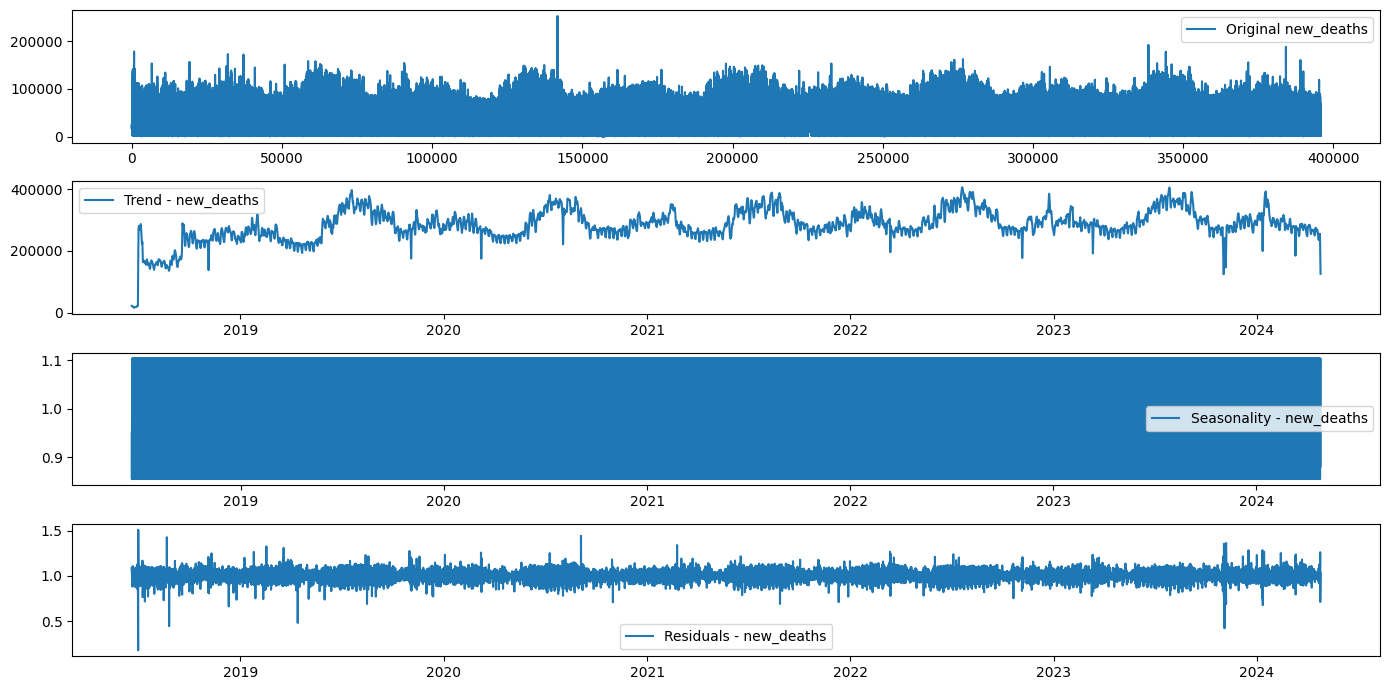

In [23]:
decomposition = seasonal_decompose(df_graph[target_column], model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(df[target_column], label=f"Original value")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(trend, label=f"Trend - value")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal, label=f"Seasonality - value")
plt.legend(loc="best")

plt.subplot(414)
plt.plot(residual, label=f"Residuals - value")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


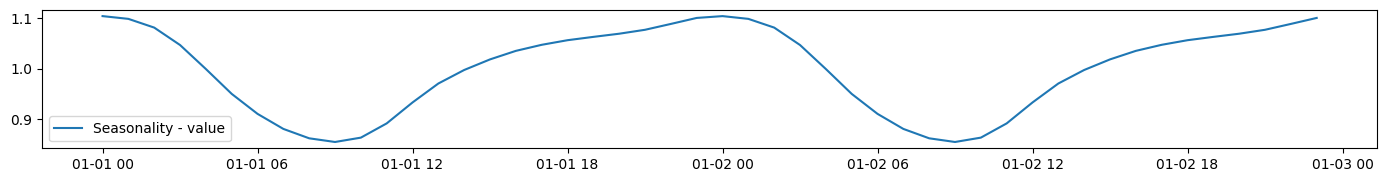

In [28]:
seasonal_closer = decomposition.seasonal["2020-01-01": "2020-01-02"]

plt.figure(figsize=(14, 7))
plt.subplot(413)
plt.plot(seasonal_closer, label=f"Seasonality - value")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Plot ACF and PACF

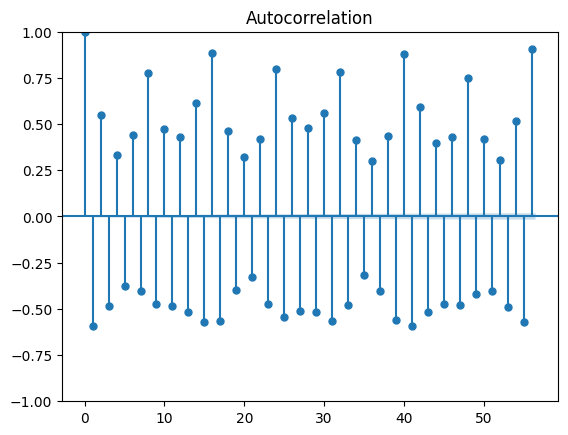

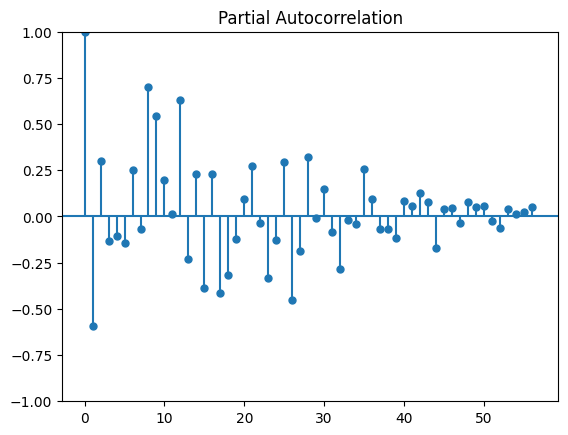

In [34]:
plot_acf(df_graph[[target_column]])
plt.show()

plot_pacf(df_graph[[target_column]])
plt.show()

Determine whether the dataset is stationary

In [32]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)


adf_test(df_graph[target_column])

1. ADF :  -8.197358867271847
2. P-Value :  7.387593605758771e-13
3. Num Of Lags :  58
4. Num Of Observations Used For ADF Regression: 51232
5. Critical Values :
	 1% :  -3.43047764732349
	 5% :  -2.861596417525354
	 10% :  -2.566800029177643


In [33]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, tsmode=True)
profile.to_file("profile_report.html")

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuell/.local/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/samuell/.local/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecat

In [11]:
df = df[(df[date_column] >= "2023-01-01") & (df[date_column] <= "2024-04-24")]

In [12]:
df_by_parent = df.groupby('parent')


In [13]:
df

,period,parent,value
304479,2023-01-01,CISO,24007.0
304480,2023-01-01,ERCO,40760.0
304481,2023-01-01,ISNE,13854.0
304482,2023-01-01,MISO,70159.0
304483,2023-01-01,NYIS,17580.0
...,...,...,...
395561,2024-04-24,MISO,67270.0
395562,2024-04-24,NYIS,16269.0
395563,2024-04-24,PJM,84210.0
395564,2024-04-24,PNM,1718.0


In [14]:

from scipy.ndimage import shift

all_dates = pd.date_range(start=df[date_column].min(), end=df[date_column].max(), freq='H')
groups = []
for name, group in df_by_parent:
    df_all_dates = pd.DataFrame(all_dates, columns=[date_column])
    full_dates = pd.merge(df_all_dates, group, on=date_column, how='left')
    full_dates['parent'] = name
    full_dates[target_column].fillna(0, inplace=True)
    tmp_df = full_dates.copy().iloc[30:]
    new_column_cases = shift(full_dates[target_column], shift=30)[30:]
    tmp_df['value_30_hours_ago'] = new_column_cases
    groups.append(tmp_df)
new_df = pd.concat(groups, ignore_index=True)
new_df[target_column] = new_df[target_column].astype(int)
new_df[target_column] += 1
new_df['value_30_hours_ago'] = new_df['value_30_hours_ago'].astype(int)
new_df['value_30_hours_ago'] += 1
new_df.to_csv('./data/parsed_dataset.csv', index=False)